# Neural Ordinary Differential Equations
## Summary

NeurIPS is the largest AI conference in the world. 4,854 papers were submitted. 4 received "Best paper" award. This is one of them. The basic idea is that neural networks are made up of stacked layers of simple computation nodes that work together to approximate a function. If we re-frame a neural network as an "Ordinary Differential Equation", we can use existing ODE solvers (like Euler's method) to approximate a function. This means no discrete layers, instead the network is a continous function. No more specifying the # of layers beforehand, instead specify the desired accuracy, it will learn how to train itself within that margin of error. It's still early stages, but this could be as big a breakthrough as GANs! 

<table>
    <tr>
        <td> <img src="images/resnet_0_viz.png" alt="Drawing" style="width: 450px;"/> </td>
        <td> <img src="images/odenet_0_viz.png" alt="Drawing" style="width: 450px;"/> </td>
    </tr>
</table>

 -  Left: A Residual network defines a discrete sequence of finite transformations.
 -  Right: A ODE network defines a vector field, which continuously transforms the state.
 -  Both: Circles represent evaluation locations

## Demo 
An ODENet approximated this spiral function better than a Recurrent Network. 

![alt text](images/demon-timeseries.png)

ODENet give comparable result to ResNet but cheaper in memory
![Ode vs ResNet](images/resnet-vs-ode.png)


## Why Does this matter? 

1. Faster testing time than recurrent networks, but slower training time. Perfect for low power edge computing! (precision vs speed)
2. More accurate results for time series predictions (!!) i.e continous-time models
3. Opens up a whole new realm of mathematics for optimizing neural networks (Diff Equation Solvers, 100+ years of theory)
4, Compute gradients with constant memory cost

## Resources
 - Paper: https://nips.cc/Conferences/2018/Schedule?showEvent=11635
 - Siraj Rava github: https://github.com/llSourcell/Neural_Differential_Equations
 - torchdiffeq in github: https://github.com/rtqichen/torchdiffeq

To install torchdiffeq:
pip install git+https://github.com/rtqichen/torchdiffeq.git



# Neural Network, Global Approximators

From Universal Approximation Theorem, a network made of linear matrix multiplication followed by a non-linear function can approximate any arbitrary continuous function. 

# Residual Neural Network

A solution to this was proposed by Microsoft for the 2015 ImageNet competiton (residual networks)
- In December of  2015, Microsoft proposed "Residual networks" as a solution to the ImageNet Classification Competition
- ResNets had the best accuracy in the competition
- ResNets utilize "skip-connections" between layers, which increases accuracy.
- They were able to train networks of up to 1000 layers deep while avoiding vanishing gradients (lower accuracy)
- 6 months later, their publicatio already had more than 200 references.

The residual layer is actually quite simple: add the output of the activation function to the original input to the layer. As a formula, the k+1th layer has the formula:

\begin{equation} x_{k+1} = x_{k} + F(x_{k})\end{equation}

where F is the function of the kth layer and its activation. For example, F might represent a convolutional layer with a relu activation. This simple formula is a special case of the formula:

\begin{equation} x_{k+1} = x_{k} + h F(x_k),\end{equation}

which is the formula for the Euler method for solving ordinary differential equations (ODEs) when h=1

# Euler Expansion

Consider a simplified ODE from physics: we want to model the position x of a marble. Assume we can calculate its velocity x′ (the derivative of position) at any position x. We know that the marble starts at rest x(0)=0 and that its velocity at time t depends on its position through the formula:

\begin{equation} \dot{x}(t) = f(x) \end{equation}

The Euler method solves this problem by following the physical intuition: my position at a time very close to the present depends on my current velocity and position. For example, if you are travelling at a velocity of 5 meters per second, and you travel 1 second, your position changes by 5 meters. If we travel h seconds, we will have travelled 5h meters. As a formula, we said:

\begin{equation}x(t+h) = x(t) + h \dot{x}(t),\end{equation}

but since we know

\begin{equation} \dot{x}(t) = f(x) \end{equation}

we can rewrite this as

\begin{equation} x(t+h) = x(t) + h f(x).\end{equation}

If you squint at this formula for the Euler method, you can see it looks just like the formula for residual layers!

This observation has meant three things for designing neural networks:

- New neural network layers can be created through different numerical approaches to solving ODEs
- The possibility of arbitrarily deep neural networks
- Training of a deep network can be improved by considering the so-called stability of the underlying ODE and its numerical discretization




## What Does an ODENet Look like? 

*An ODE is a function that usually describes the change of some system through time. In this setting, time is a continuous variable. Now imagine a neural network is that system, and time is really something more like the depth of the network. Note that there are usually a discrete number of layers in an ANN. This is a notion of continuous number of layers.*

- The team didn't use Euler's method, they computed the exact ODE solution (within a small error tolerance) using adaptive solvers (faster)
- The dynamics change smoothly with depth. You can think of this either as having weights that are a function of depth, or as having shared weights across layers but adding the depth as an extra input to f.
- Anywhere you can put a resnet you can put an ODEnet.
- Each ODEBlock can be used to replace a whole stack of ResBlocks.
- In their MNIST example, each ODEBlock replaces 6 ResBlocks.

### Traditional Deep Nets


```
h1 = f1(x)
h2 = f2(h1)
h3 = f3(h2)
h4 = f3(h3)
y  = f5(h4)
```

### ResNets

```
h1 = f1(x)  + x
h2 = f2(h1) + h1
h3 = f3(h2) + h2
h4 = f4(h3) + h3
y  = f5(h4) + h4
```


- Where f1, f2, etc are neural net layers.
- The idea is that it's easier to model a small change to an almost-correct answer than to output the whole improved answer at once.
-This looks like a primitive ODE solver (Euler's method) that solves the trajectory of a system by just taking small steps in the direction of the system dynamics and adding them up.
-They connection allows for better training methods.
- What if we define a deep net as a continuously evolving system? 
- Instead of updating the hidden units layer by layer, we define their derivative with respect to depth instead
- We can use off-the-shelf adaptive ODE solvers to compute the final state of these dynamics, and call that the output of the neural network. 




## Reverse-mode automatic differentiation of ODE solution
The main technical difficulty in training continuous-depth is performing revese-mode differentiation (backpropagation) through ODE solver. Differentiation through the operation fo hte forward pass is straightforward, but incurs a high memory cost and intrdouces additional numerical cost.




### The Adjoint Method
Consider optimising a scalar-valued loss function $L()$, whose input is the result of an ODE solver

\begin{equation}
    L(z(t_1)) = L(\text{ODESolve}(z(t_0),f,t_0,t_1,\theta))
\end{equation}

To optimise $L$, we require the gradient with respect to parameters: $z(t_0), t_0, t_1,\text{and } \theta$.

- This approach computes gradients by solving a second, augmented ODE backwards in time, and is applicable to all ODE solvers. 
- This approach scales linearly with problem size, has low memory cost, and explicitly controls numerical error.
- The adjoint captures how the loss function L changes with respect to the hidden state.
- Starting from the output of the network, we can recompute the hidden state backwards in time together with the adjoint.



![alt text](images/NODEs-Fig-2.jpeg?w=480)

- A third integral then tells us how the loss changes with the parameters \theta ( dL/d\theta).
- All three of these integrals can be computed in a single call to an ODE solver, which concatenates the original state, the adjoint, and the other partial derivatives into a single vector. 
- Algorithm 1 shows how to construct the necessary dynamics, and call an ODE solver to compute all gradients at once.

![alt text](images/NODEs-Alg-1.jpeg?w=640)


### Implementation

- To create arbitrarily deep networks with a finite memory footprint, design neural networks based on stable ODEs and numerical discretizations.
- Create ODEFunc class to calculate the dervivative
- Call ODENet black box function inside a ODEBlock class


# Latent ODE

In [1]:
%matplotlib inline

In [2]:
import os
import argparse
import logging
import time
import numpy as np
import numpy.random as npr
import matplotlib
#matplotlib.use('agg')
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

In [3]:
niters = 2000
lr = 0.01
gpu = 0
train_dir = 'data'

In [4]:
from torchdiffeq import odeint
#from torchdiffeq import odeint_adjoint as odeint

### Generate trajectory

In [5]:
def generate_spiral2d(nspiral=1000,
                      ntotal=500,
                      nsample=100,
                      start=0.,
                      stop=1,  # approximately equal to 6pi
                      noise_std=.1,
                      a=0.,
                      b=1.,
                      savefig=True):
    """Parametric formula for 2d spiral is `r = a + b * theta`.
    Args:
      nspiral: number of spirals, i.e. batch dimension
      ntotal: total number of datapoints per spiral
      nsample: number of sampled datapoints for model fitting per spiral
      start: spiral starting theta value
      stop: spiral ending theta value
      noise_std: observation noise standard deviation
      a, b: parameters of the Archimedean spiral
      savefig: plot the ground truth for sanity check
    Returns: 
      Tuple where first element is true trajectory of size (nspiral, ntotal, 2),
      second element is noisy observations of size (nspiral, nsample, 2),
      third element is timestamps of size (ntotal,),
      and fourth element is timestamps of size (nsample,)
    """

    # add 1 all timestamps to avoid division by 0
    orig_ts = np.linspace(start, stop, num=ntotal)
    samp_ts = orig_ts[:nsample]

    # generate clock-wise and counter clock-wise spirals in observation space
    # with two sets of time-invariant latent dynamics
    zs_cw = stop + 1. - orig_ts
    rs_cw = a + b * 50. / zs_cw
    xs, ys = rs_cw * np.cos(zs_cw) - 5., rs_cw * np.sin(zs_cw)
    orig_traj_cw = np.stack((xs, ys), axis=1)

    zs_cc = orig_ts
    rw_cc = a + b * zs_cc
    xs, ys = rw_cc * np.cos(zs_cc) + 5., rw_cc * np.sin(zs_cc)
    orig_traj_cc = np.stack((xs, ys), axis=1)

    if savefig:
        plt.figure()
        plt.plot(orig_traj_cw[:, 0], orig_traj_cw[:, 1], label='clock')
        plt.plot(orig_traj_cc[:, 0], orig_traj_cc[:, 1], label='counter clock')
        plt.legend()
        plt.savefig('./ground_truth.png', dpi=500)
        print('Saved ground truth spiral at {}'.format('./ground_truth.png'))

    # sample starting timestamps
    orig_trajs = []
    samp_trajs = []
    for _ in range(nspiral):
        # don't sample t0 very near the start or the end
        t0_idx = npr.multinomial(
            1, [1. / (ntotal - 2. * nsample)] * (ntotal - int(2 * nsample)))
        t0_idx = np.argmax(t0_idx) + nsample

        cc = bool(npr.rand() > .5)  # uniformly select rotation
        orig_traj = orig_traj_cc if cc else orig_traj_cw
        orig_trajs.append(orig_traj)

        samp_traj = orig_traj[t0_idx:t0_idx + nsample, :].copy()
        samp_traj += npr.randn(*samp_traj.shape) * noise_std
        samp_trajs.append(samp_traj)

    # batching for sample trajectories is good for RNN; batching for original
    # trajectories only for ease of indexing
    orig_trajs = np.stack(orig_trajs, axis=0)
    samp_trajs = np.stack(samp_trajs, axis=0)

    return orig_trajs, samp_trajs, orig_ts, samp_ts

### ODE Function
This is the function that corresponds to derivative, create a block that you need to integrate like in ResNet (ResNet Block you keep repeating)

In [6]:
class LatentODEfunc(nn.Module):

    def __init__(self, latent_dim=4, nhidden=20):
        super(LatentODEfunc, self).__init__()
        self.elu = nn.ELU(inplace=True)
        self.fc1 = nn.Linear(latent_dim, nhidden)
        self.fc2 = nn.Linear(nhidden, nhidden)
        self.fc3 = nn.Linear(nhidden, latent_dim)
        self.nfe = 0

    def forward(self, t, x):
        self.nfe += 1
        out = self.fc1(x)
        out = self.elu(out)
        out = self.fc2(out)
        out = self.elu(out)
        out = self.fc3(out)
        return out

In [7]:
class RecognitionRNN(nn.Module):

    def __init__(self, latent_dim=4, obs_dim=2, nhidden=25, nbatch=1):
        super(RecognitionRNN, self).__init__()
        self.nhidden = nhidden
        self.nbatch = nbatch
        self.i2h = nn.Linear(obs_dim + nhidden, nhidden)
        self.h2o = nn.Linear(nhidden, latent_dim * 2)

    def forward(self, x, h):
        combined = torch.cat((x, h), dim=1)
        h = torch.tanh(self.i2h(combined))
        out = self.h2o(h)
        return out, h

    def initHidden(self):
        return torch.zeros(self.nbatch, self.nhidden)

In [8]:
class Decoder(nn.Module):

    def __init__(self, latent_dim=4, obs_dim=2, nhidden=20):
        super(Decoder, self).__init__()
        self.relu = nn.ReLU(inplace=True)
        self.fc1 = nn.Linear(latent_dim, nhidden)
        self.fc2 = nn.Linear(nhidden, obs_dim)

    def forward(self, z):
        out = self.fc1(z)
        out = self.relu(out)
        out = self.fc2(out)
        return out


In [9]:
class RunningAverageMeter(object):
    """Computes and stores the average and current value"""

    def __init__(self, momentum=0.99):
        self.momentum = momentum
        self.reset()

    def reset(self):
        self.val = None
        self.avg = 0

    def update(self, val):
        if self.val is None:
            self.avg = val
        else:
            self.avg = self.avg * self.momentum + val * (1 - self.momentum)
        self.val = val


In [10]:
def log_normal_pdf(x, mean, logvar):
    const = torch.from_numpy(np.array([2. * np.pi])).float().to(x.device)
    const = torch.log(const)
    return -.5 * (const + logvar + (x - mean) ** 2. / torch.exp(logvar))


# Variational autoencoder (VAE)
Variational autoencoders are a slightly more modern and interesting take on autoencoding.

What is a variational autoencoder, you ask? It's a type of autoencoder with added constraints on the encoded representations being learned. More precisely, it is an autoencoder that learns a latent variable model for its input data. So instead of letting your neural network learn an arbitrary function, you are learning the parameters of a probability distribution modeling your data. If you sample points from this distribution, you can generate new input data samples: a VAE is a "generative model".

Let’s define some notions:
1. $X$: data that we want to model a.k.a the animal
2. $z$: latent variable a.k.a our imagination
3. $p(X)$: probability density of the data, i.e. that animal kingdom
4. $p(z)$: probability density of latent variable, i.e. our brain, the source of our imagination
5. $p(X|z)$: probability density of generating data given latent variable, e.g. turning imagination into real animal


Our objective here is to model the data, hence we want to find $p(X)$ Using the law of probability, we could find it in relation with $z$ as follows:
<h1><center>$p(X) = \int p(X|z)p(z)dz$</center></h1>
that is, we marginalize out $z$ from the joint probability distribution $P(X,z)$.

The idea of VAE is to infer $p(z)$ using $p(z|X)$. This is make a lot of sense if we think about it: we want to make our latent variable likely under our data. Talking in term of our fable example, we want to limit our imagination only on animal kingdom domain, so we shouldn’t imagine about things like root, leaf, tyre, glass, GPU, refrigerator, doormat, … as it’s unlikely that those things have anything to do with things that come from the animal kingdom. Right?

But the problem is, we have to infer that density  $p(z|X)$, as we don’t know it yet. In VAE, as it name suggests, we infer $p(z|X)$ using a method called Variational Inference (VI). VI is one of the popular choice of method in bayesian inference, the other one being MCMC method. The main idea of VI is to pose the inference by approach it as an optimization problem. How? By modeling the true density $p(z|X)$ using simpler density that is easy to evaluate, e.g. Gaussian, and minimize the difference between those two density using KL divergence metric, which tells us how difference it is $p$ and $q$.

# Kullback–Leibler divergence
Alright, now let’s say we want to infer $p(z|X)$ using $q(z|X)$. The KL divergence then formulated as follows:
<h1><center>$D_{KL}[q[z|X)||p(z|X)] = \sum_z q(z|X) \log \frac{q(z|X)}{p(z|X)} = E_q[\log q(z|X) - \log p(z|X)]$</center></h1>
# What KL-Divergence do?
* allows use to compare 2 probability distributions
* if $q$ is the same as  $p$, then KLD = 0
* if $q$ is different from  $p$, KLD > 0

# The cost function
The cost function we want to minimise is the negative of the evidence lower bound: 'ELBO':
<h1><center>$ELBO = E[\log p(X|z)] - D_{KL} [q(z|X) ||p(z)]$</center></h1>

The first term is $E_q[\log p(X|z)]$ is the cross entropy we know. 
The second term is the KL divergence between the prior $p(z)$ and our latent model. We can choose the prior density any density we want, but it is much simpler to use normal density function: $p(z) = \mathcal{N}(0,1)$. 

# KL distribution between two normal distribution
I am using book: The Matrix Cookbook from: http://coin.wne.uw.edu.pl/pbiernacki/matrix_cookbook.pdf
1. $q(z|X) = \mathcal{N}(\mu_1, \Sigma_1^2)$
2. $p(z) = \mathcal{N}(\mu_2, \Sigma_2^2)$
3. $D_{KL}[q(z|X)||p(z:X)] = \int p(z) [\log p(z) - \log q(z|X)] dz$
4. $D_{KL}[\mathcal{N}(\mu_1, \Sigma_1)||\mathcal{N}(\mu_2,\Sigma_2)]= \frac{1}{2} [\log \frac{|\Sigma_2|}{|\Sigma_1|} - d  + tr{\Sigma_2^{-1}\Sigma_1} + (\mu_2-\mu_1)^T\Sigma_2^{-1}(\mu_2-\mu_1)]$
4. $d$ is the dimension of the latent vector.

If we have $d=1$, and $p(x) = \mathcal{N}(0,1)$ then the formula becomes very simple.
$KL [\mathcal{N}(\mu, \Sigma^2) || \mathcal{N}(0,1)  ] = \frac{1}{2}(\log(\Sigma) -1  + \Sigma + \mu^2)$ 

In [16]:
#tensor flow allows you to get the KL between two distribution...
import numpy as np
import tensorflow as tf
import tensorflow.contrib.distributions as dis
Normal = tf.contrib.distributions.Normal
t = dis.kl_divergence(Normal(3.0, 2.0), Normal(0.0, 1.0))
t2  =  dis.kl_divergence(Normal(3.0, 1.0), Normal(2.9,1.0))
t3 =  dis.kl_divergence(Normal(3.0, 1.0), Normal(3.0,1.0))

#Multivariate Normal distribution
mu1 =np.array( [1.,2])
cov1=np.array([[3,3/5], [3/5,2]])


mu2 = np.array([4,2.1])
cov2= np.array([[1,3/5], [3/5,2]])

tmvn = dis.kl_divergence(tf.contrib.distributions.MultivariateNormalFullCovariance(loc=mu1,covariance_matrix=cov1),
        tf.contrib.distributions.MultivariateNormalFullCovariance(
           loc=mu2,
           covariance_matrix=cov2) )


with tf.Session() as session:
    t_val = session.run(t)
    print ('KLD(N(3,2), N(0,1)) =', t_val, ", value = ", .5*(np.log(2)  - 1  + 2.0 + 3**2 ))
    t_val = session.run(t2)
    print('KLD(N(3,1), N(2.9,1)) =', t_val)
    t_val = session.run(t3)
    print('KLD(N(3,1), N(3,1)) =', t_val)
    t_val =session.run(tmvn)
    print('KLD(MVN1, MVN2)  = ', t_val)



KLD(N(3,2), N(0,1)) = 5.306853 , value =  5.346573590279973
KLD(N(3,1), N(2.9,1)) = 0.0049999906
KLD(N(3,1), N(3,1)) = 0.0
KLD(MVN1, MVN2)  =  5.98301584426063


$D_{KL}[\mathcal{N}(\mu_1, \Sigma_1)||\mathcal{N}(\mu_2,\Sigma_2)]= \frac{1}{2} [\log \frac{|\Sigma_2|}{|\Sigma_1|} - d  + tr{\Sigma_2^{-1}\Sigma_1} + (\mu_2-\mu_1)^T\Sigma_2^{-1}(\mu_2-\mu_1)]$

In [15]:


dkl = 0.5*(np.log(np.linalg.det(cov2)/np.linalg.det(cov1) )- 2 + 
           np.trace(np.linalg.inv(cov2)@cov1) + np.transpose(mu2-mu1)@np.linalg.inv(cov2)@(mu2-mu1))
print(dkl)


5.98301584426063


# Implementation of KL divergence

In [11]:
def normal_kl(mu1, lv1, mu2, lv2):
    v1 = torch.exp(lv1)
    v2 = torch.exp(lv2)
    lstd1 = lv1 / 2.
    lstd2 = lv2 / 2.

    kl = lstd2 - lstd1 + ((v1 + (mu1 - mu2) ** 2.) / (2. * v2)) - .5
    return kl

Saved ground truth spiral at ./ground_truth.png


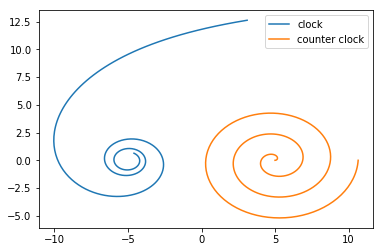

In [12]:
latent_dim = 4
nhidden = 20
rnn_nhidden = 25
obs_dim = 2
nspiral = 1000
start = 0.
stop = 6 * np.pi
noise_std = .3
a = 0.
b = .3
ntotal = 1000
nsample = 100
device = torch.device('cuda:' + str(gpu)
                      if torch.cuda.is_available() else 'cpu')

# generate toy spiral data
orig_trajs, samp_trajs, orig_ts, samp_ts = generate_spiral2d(
    nspiral=nspiral,
    start=start,
    stop=stop,
    noise_std=noise_std,
    a=a, b=b
)
orig_trajs = torch.from_numpy(orig_trajs).float().to(device)
samp_trajs = torch.from_numpy(samp_trajs).float().to(device)
samp_ts = torch.from_numpy(samp_ts).float().to(device)

# model
func = LatentODEfunc(latent_dim, nhidden).to(device)
rec = RecognitionRNN(latent_dim, obs_dim, rnn_nhidden, nspiral).to(device)
dec = Decoder(latent_dim, obs_dim, nhidden).to(device)
params = (list(func.parameters()) + list(dec.parameters()) + list(rec.parameters()))
optimizer = optim.Adam(params, lr=lr)
loss_meter = RunningAverageMeter()

In [13]:
if train_dir is not None:
    if not os.path.exists(train_dir):
        os.makedirs(train_dir)
    ckpt_path = os.path.join(train_dir, 'ckpt.pth')
    if os.path.exists(ckpt_path):
        checkpoint = torch.load(ckpt_path)
        func.load_state_dict(checkpoint['func_state_dict'])
        rec.load_state_dict(checkpoint['rec_state_dict'])
        dec.load_state_dict(checkpoint['dec_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        orig_trajs = checkpoint['orig_trajs']
        samp_trajs = checkpoint['samp_trajs']
        orig_ts = checkpoint['orig_ts']
        samp_ts = checkpoint['samp_ts']
        print('Loaded ckpt from {}'.format(ckpt_path))





In [14]:
try:
    for itr in range(1, niters + 1):
        optimizer.zero_grad()
        # backward in time to infer q(z_0)
        h = rec.initHidden().to(device)
        for t in reversed(range(samp_trajs.size(1))):
            obs = samp_trajs[:, t, :]
            out, h = rec.forward(obs, h)
        qz0_mean, qz0_logvar = out[:, :latent_dim], out[:, latent_dim:]
        epsilon = torch.randn(qz0_mean.size()).to(device)
        z0 = epsilon * torch.exp(.5 * qz0_logvar) + qz0_mean

        # forward in time and solve ode for reconstructions
        pred_z = odeint(func, z0, samp_ts).permute(1, 0, 2)
        pred_x = dec(pred_z)

        # compute loss
        noise_std_ = torch.zeros(pred_x.size()).to(device) + noise_std
        noise_logvar = 2. * torch.log(noise_std_).to(device)
        logpx = log_normal_pdf(
            samp_trajs, pred_x, noise_logvar).sum(-1).sum(-1)
        pz0_mean = pz0_logvar = torch.zeros(z0.size()).to(device)
        analytic_kl = normal_kl(qz0_mean, qz0_logvar,
                                pz0_mean, pz0_logvar).sum(-1)
        print(analytic_kl.shape, logpx.shape)
        loss = torch.mean(-logpx + analytic_kl, dim=0)
        loss.backward()
        optimizer.step()
        loss_meter.update(loss.item())

        print('Iter: {}, running avg elbo: {:.4f}'.format(itr, -loss_meter.avg))

except KeyboardInterrupt:
    if train_dir is not None:
        ckpt_path = os.path.join(train_dir, 'ckpt.pth')
        torch.save({
            'func_state_dict': func.state_dict(),
            'rec_state_dict': rec.state_dict(),
            'dec_state_dict': dec.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'orig_trajs': orig_trajs,
            'samp_trajs': samp_trajs,
            'orig_ts': orig_ts,
            'samp_ts': samp_ts,
        }, ckpt_path)
        print('Stored ckpt at {}'.format(ckpt_path))
print('Training complete after {} iters.'.format(itr))

torch.Size([1000]) torch.Size([1000])
Iter: 1, running avg elbo: -19535.5879
torch.Size([1000]) torch.Size([1000])
Iter: 2, running avg elbo: -19530.3142
torch.Size([1000]) torch.Size([1000])
Iter: 3, running avg elbo: -19518.7045
torch.Size([1000]) torch.Size([1000])
Iter: 4, running avg elbo: -19496.9007
torch.Size([1000]) torch.Size([1000])
Iter: 5, running avg elbo: -19457.2090
torch.Size([1000]) torch.Size([1000])
Iter: 6, running avg elbo: -19395.6494
torch.Size([1000]) torch.Size([1000])
Iter: 7, running avg elbo: -19310.5058
torch.Size([1000]) torch.Size([1000])
Iter: 8, running avg elbo: -19213.9872
torch.Size([1000]) torch.Size([1000])
Iter: 9, running avg elbo: -19116.8167
torch.Size([1000]) torch.Size([1000])
Iter: 10, running avg elbo: -19016.6774
torch.Size([1000]) torch.Size([1000])
Iter: 11, running avg elbo: -18906.9432
torch.Size([1000]) torch.Size([1000])
Iter: 12, running avg elbo: -18793.7587
torch.Size([1000]) torch.Size([1000])
Iter: 13, running avg elbo: -18680.

Iter: 106, running avg elbo: -10789.1322
torch.Size([1000]) torch.Size([1000])
Iter: 107, running avg elbo: -10735.9520
torch.Size([1000]) torch.Size([1000])
Iter: 108, running avg elbo: -10683.3463
torch.Size([1000]) torch.Size([1000])
Iter: 109, running avg elbo: -10631.0337
torch.Size([1000]) torch.Size([1000])
Iter: 110, running avg elbo: -10579.2785
torch.Size([1000]) torch.Size([1000])
Iter: 111, running avg elbo: -10527.8385
torch.Size([1000]) torch.Size([1000])
Iter: 112, running avg elbo: -10476.9238
torch.Size([1000]) torch.Size([1000])
Iter: 113, running avg elbo: -10426.4583
torch.Size([1000]) torch.Size([1000])
Iter: 114, running avg elbo: -10376.1131
torch.Size([1000]) torch.Size([1000])
Iter: 115, running avg elbo: -10326.2520
torch.Size([1000]) torch.Size([1000])
Iter: 116, running avg elbo: -10276.9101
torch.Size([1000]) torch.Size([1000])
Iter: 117, running avg elbo: -10227.5972
torch.Size([1000]) torch.Size([1000])
Iter: 118, running avg elbo: -10178.7836
torch.Size(

Iter: 211, running avg elbo: -6017.8319
torch.Size([1000]) torch.Size([1000])
Iter: 212, running avg elbo: -5977.7147
torch.Size([1000]) torch.Size([1000])
Iter: 213, running avg elbo: -5937.9023
torch.Size([1000]) torch.Size([1000])
Iter: 214, running avg elbo: -5898.3608
torch.Size([1000]) torch.Size([1000])
Iter: 215, running avg elbo: -5858.8377
torch.Size([1000]) torch.Size([1000])
Iter: 216, running avg elbo: -5819.2010
torch.Size([1000]) torch.Size([1000])
Iter: 217, running avg elbo: -5779.9836
torch.Size([1000]) torch.Size([1000])
Iter: 218, running avg elbo: -5740.9061
torch.Size([1000]) torch.Size([1000])
Iter: 219, running avg elbo: -5702.1426
torch.Size([1000]) torch.Size([1000])
Iter: 220, running avg elbo: -5663.2361
torch.Size([1000]) torch.Size([1000])
Iter: 221, running avg elbo: -5624.8136
torch.Size([1000]) torch.Size([1000])
Iter: 222, running avg elbo: -5586.9187
torch.Size([1000]) torch.Size([1000])
Iter: 223, running avg elbo: -5548.8436
torch.Size([1000]) torch

torch.Size([1000]) torch.Size([1000])
Iter: 317, running avg elbo: -2971.3205
torch.Size([1000]) torch.Size([1000])
Iter: 318, running avg elbo: -2950.5413
torch.Size([1000]) torch.Size([1000])
Iter: 319, running avg elbo: -2929.8111
torch.Size([1000]) torch.Size([1000])
Iter: 320, running avg elbo: -2909.1912
torch.Size([1000]) torch.Size([1000])
Iter: 321, running avg elbo: -2888.4959
torch.Size([1000]) torch.Size([1000])
Iter: 322, running avg elbo: -2867.9616
torch.Size([1000]) torch.Size([1000])
Iter: 323, running avg elbo: -2847.6326
torch.Size([1000]) torch.Size([1000])
Iter: 324, running avg elbo: -2827.3547
torch.Size([1000]) torch.Size([1000])
Iter: 325, running avg elbo: -2807.3130
torch.Size([1000]) torch.Size([1000])
Iter: 326, running avg elbo: -2787.4863
torch.Size([1000]) torch.Size([1000])
Iter: 327, running avg elbo: -2767.5131
torch.Size([1000]) torch.Size([1000])
Iter: 328, running avg elbo: -2747.7695
torch.Size([1000]) torch.Size([1000])
Iter: 329, running avg elb

Iter: 422, running avg elbo: -1380.1785
torch.Size([1000]) torch.Size([1000])
Iter: 423, running avg elbo: -1370.1715
torch.Size([1000]) torch.Size([1000])
Iter: 424, running avg elbo: -1360.2776
torch.Size([1000]) torch.Size([1000])
Iter: 425, running avg elbo: -1350.4057
torch.Size([1000]) torch.Size([1000])
Iter: 426, running avg elbo: -1340.6170
torch.Size([1000]) torch.Size([1000])
Iter: 427, running avg elbo: -1330.9380
torch.Size([1000]) torch.Size([1000])
Iter: 428, running avg elbo: -1321.3048
torch.Size([1000]) torch.Size([1000])
Iter: 429, running avg elbo: -1311.7976
torch.Size([1000]) torch.Size([1000])
Iter: 430, running avg elbo: -1302.4043
torch.Size([1000]) torch.Size([1000])
Iter: 431, running avg elbo: -1293.2819
torch.Size([1000]) torch.Size([1000])
Iter: 432, running avg elbo: -1284.1637
torch.Size([1000]) torch.Size([1000])
Iter: 433, running avg elbo: -1275.0650
torch.Size([1000]) torch.Size([1000])
Iter: 434, running avg elbo: -1265.9724
torch.Size([1000]) torch

Iter: 528, running avg elbo: -647.8312
torch.Size([1000]) torch.Size([1000])
Iter: 529, running avg elbo: -643.2264
torch.Size([1000]) torch.Size([1000])
Iter: 530, running avg elbo: -638.7413
torch.Size([1000]) torch.Size([1000])
Iter: 531, running avg elbo: -634.3203
torch.Size([1000]) torch.Size([1000])
Iter: 532, running avg elbo: -629.9080
torch.Size([1000]) torch.Size([1000])
Iter: 533, running avg elbo: -625.4714
torch.Size([1000]) torch.Size([1000])
Iter: 534, running avg elbo: -621.1449
torch.Size([1000]) torch.Size([1000])
Iter: 535, running avg elbo: -616.8236
torch.Size([1000]) torch.Size([1000])
Iter: 536, running avg elbo: -612.4893
torch.Size([1000]) torch.Size([1000])
Iter: 537, running avg elbo: -608.2462
torch.Size([1000]) torch.Size([1000])
Iter: 538, running avg elbo: -604.0622
torch.Size([1000]) torch.Size([1000])
Iter: 539, running avg elbo: -599.9226
torch.Size([1000]) torch.Size([1000])
Iter: 540, running avg elbo: -595.8000
torch.Size([1000]) torch.Size([1000])

torch.Size([1000]) torch.Size([1000])
Iter: 635, running avg elbo: -333.3416
torch.Size([1000]) torch.Size([1000])
Iter: 636, running avg elbo: -331.4429
torch.Size([1000]) torch.Size([1000])
Iter: 637, running avg elbo: -329.6222
torch.Size([1000]) torch.Size([1000])
Iter: 638, running avg elbo: -327.8175
torch.Size([1000]) torch.Size([1000])
Iter: 639, running avg elbo: -325.9902
torch.Size([1000]) torch.Size([1000])
Iter: 640, running avg elbo: -324.1880
torch.Size([1000]) torch.Size([1000])
Iter: 641, running avg elbo: -322.4015
torch.Size([1000]) torch.Size([1000])
Iter: 642, running avg elbo: -320.6270
torch.Size([1000]) torch.Size([1000])
Iter: 643, running avg elbo: -318.8484
torch.Size([1000]) torch.Size([1000])
Iter: 644, running avg elbo: -317.0965
torch.Size([1000]) torch.Size([1000])
Iter: 645, running avg elbo: -315.3663
torch.Size([1000]) torch.Size([1000])
Iter: 646, running avg elbo: -313.6562
torch.Size([1000]) torch.Size([1000])
Iter: 647, running avg elbo: -311.9277

Iter: 741, running avg elbo: -211.9430
torch.Size([1000]) torch.Size([1000])
Iter: 742, running avg elbo: -211.1562
torch.Size([1000]) torch.Size([1000])
Iter: 743, running avg elbo: -210.3593
torch.Size([1000]) torch.Size([1000])
Iter: 744, running avg elbo: -209.5620
torch.Size([1000]) torch.Size([1000])
Iter: 745, running avg elbo: -208.7926
torch.Size([1000]) torch.Size([1000])
Iter: 746, running avg elbo: -208.0062
torch.Size([1000]) torch.Size([1000])
Iter: 747, running avg elbo: -207.2245
torch.Size([1000]) torch.Size([1000])
Iter: 748, running avg elbo: -206.4497
torch.Size([1000]) torch.Size([1000])
Iter: 749, running avg elbo: -205.6796
torch.Size([1000]) torch.Size([1000])
Iter: 750, running avg elbo: -204.9186
torch.Size([1000]) torch.Size([1000])
Iter: 751, running avg elbo: -204.1482
torch.Size([1000]) torch.Size([1000])
Iter: 752, running avg elbo: -203.3792
torch.Size([1000]) torch.Size([1000])
Iter: 753, running avg elbo: -202.6120
torch.Size([1000]) torch.Size([1000])

torch.Size([1000]) torch.Size([1000])
Iter: 848, running avg elbo: -242.3361
torch.Size([1000]) torch.Size([1000])
Iter: 849, running avg elbo: -244.0467
torch.Size([1000]) torch.Size([1000])
Iter: 850, running avg elbo: -245.0896
torch.Size([1000]) torch.Size([1000])
Iter: 851, running avg elbo: -246.1654
torch.Size([1000]) torch.Size([1000])
Iter: 852, running avg elbo: -246.8510
torch.Size([1000]) torch.Size([1000])
Iter: 853, running avg elbo: -247.7242
torch.Size([1000]) torch.Size([1000])
Iter: 854, running avg elbo: -248.0394
torch.Size([1000]) torch.Size([1000])
Iter: 855, running avg elbo: -248.5447
torch.Size([1000]) torch.Size([1000])
Iter: 856, running avg elbo: -248.8290
torch.Size([1000]) torch.Size([1000])
Iter: 857, running avg elbo: -248.9842
torch.Size([1000]) torch.Size([1000])
Iter: 858, running avg elbo: -248.8860
torch.Size([1000]) torch.Size([1000])
Iter: 859, running avg elbo: -248.7676
torch.Size([1000]) torch.Size([1000])
Iter: 860, running avg elbo: -248.5630

Iter: 954, running avg elbo: -184.1770
torch.Size([1000]) torch.Size([1000])
Iter: 955, running avg elbo: -183.5660
torch.Size([1000]) torch.Size([1000])
Iter: 956, running avg elbo: -182.9533
torch.Size([1000]) torch.Size([1000])
Iter: 957, running avg elbo: -182.3509
torch.Size([1000]) torch.Size([1000])
Iter: 958, running avg elbo: -181.7512
torch.Size([1000]) torch.Size([1000])
Iter: 959, running avg elbo: -181.1623
torch.Size([1000]) torch.Size([1000])
Iter: 960, running avg elbo: -180.5759
torch.Size([1000]) torch.Size([1000])
Iter: 961, running avg elbo: -179.9796
torch.Size([1000]) torch.Size([1000])
Iter: 962, running avg elbo: -179.3926
torch.Size([1000]) torch.Size([1000])
Iter: 963, running avg elbo: -178.8205
torch.Size([1000]) torch.Size([1000])
Iter: 964, running avg elbo: -178.2519
torch.Size([1000]) torch.Size([1000])
Iter: 965, running avg elbo: -177.6873
torch.Size([1000]) torch.Size([1000])
Iter: 966, running avg elbo: -177.1275
torch.Size([1000]) torch.Size([1000])

Iter: 1060, running avg elbo: -140.8092
torch.Size([1000]) torch.Size([1000])
Iter: 1061, running avg elbo: -140.5348
torch.Size([1000]) torch.Size([1000])
Iter: 1062, running avg elbo: -140.2560
torch.Size([1000]) torch.Size([1000])
Iter: 1063, running avg elbo: -139.9976
torch.Size([1000]) torch.Size([1000])
Iter: 1064, running avg elbo: -139.7264
torch.Size([1000]) torch.Size([1000])
Iter: 1065, running avg elbo: -139.4322
torch.Size([1000]) torch.Size([1000])
Iter: 1066, running avg elbo: -139.1136
torch.Size([1000]) torch.Size([1000])
Iter: 1067, running avg elbo: -138.8009
torch.Size([1000]) torch.Size([1000])
Iter: 1068, running avg elbo: -138.5146
torch.Size([1000]) torch.Size([1000])
Iter: 1069, running avg elbo: -138.2326
torch.Size([1000]) torch.Size([1000])
Iter: 1070, running avg elbo: -137.9699
torch.Size([1000]) torch.Size([1000])
Iter: 1071, running avg elbo: -137.6985
torch.Size([1000]) torch.Size([1000])
Iter: 1072, running avg elbo: -137.4056
torch.Size([1000]) torch

torch.Size([1000]) torch.Size([1000])
Iter: 1166, running avg elbo: -121.2610
torch.Size([1000]) torch.Size([1000])
Iter: 1167, running avg elbo: -121.0699
torch.Size([1000]) torch.Size([1000])
Iter: 1168, running avg elbo: -120.8785
torch.Size([1000]) torch.Size([1000])
Iter: 1169, running avg elbo: -120.6988
torch.Size([1000]) torch.Size([1000])
Iter: 1170, running avg elbo: -120.5322
torch.Size([1000]) torch.Size([1000])
Iter: 1171, running avg elbo: -120.3592
torch.Size([1000]) torch.Size([1000])
Iter: 1172, running avg elbo: -120.1755
torch.Size([1000]) torch.Size([1000])
Iter: 1173, running avg elbo: -119.9845
torch.Size([1000]) torch.Size([1000])
Iter: 1174, running avg elbo: -119.8088
torch.Size([1000]) torch.Size([1000])
Iter: 1175, running avg elbo: -119.6382
torch.Size([1000]) torch.Size([1000])
Iter: 1176, running avg elbo: -119.4585
torch.Size([1000]) torch.Size([1000])
Iter: 1177, running avg elbo: -119.2746
torch.Size([1000]) torch.Size([1000])
Iter: 1178, running avg el

Iter: 1271, running avg elbo: -117.9378
torch.Size([1000]) torch.Size([1000])
Iter: 1272, running avg elbo: -117.8068
torch.Size([1000]) torch.Size([1000])
Iter: 1273, running avg elbo: -117.7665
torch.Size([1000]) torch.Size([1000])
Iter: 1274, running avg elbo: -117.6379
torch.Size([1000]) torch.Size([1000])
Iter: 1275, running avg elbo: -117.5207
torch.Size([1000]) torch.Size([1000])
Iter: 1276, running avg elbo: -117.4294
torch.Size([1000]) torch.Size([1000])
Iter: 1277, running avg elbo: -117.2792
torch.Size([1000]) torch.Size([1000])
Iter: 1278, running avg elbo: -117.1804
torch.Size([1000]) torch.Size([1000])
Iter: 1279, running avg elbo: -117.0185
torch.Size([1000]) torch.Size([1000])
Iter: 1280, running avg elbo: -116.8995
torch.Size([1000]) torch.Size([1000])
Iter: 1281, running avg elbo: -116.7564
torch.Size([1000]) torch.Size([1000])
Iter: 1282, running avg elbo: -116.6104
torch.Size([1000]) torch.Size([1000])
Iter: 1283, running avg elbo: -116.4900
torch.Size([1000]) torch

torch.Size([1000]) torch.Size([1000])
Iter: 1377, running avg elbo: -105.0717
torch.Size([1000]) torch.Size([1000])
Iter: 1378, running avg elbo: -104.9919
torch.Size([1000]) torch.Size([1000])
Iter: 1379, running avg elbo: -104.8956
torch.Size([1000]) torch.Size([1000])
Iter: 1380, running avg elbo: -104.7931
torch.Size([1000]) torch.Size([1000])
Iter: 1381, running avg elbo: -104.6905
torch.Size([1000]) torch.Size([1000])
Iter: 1382, running avg elbo: -104.6027
torch.Size([1000]) torch.Size([1000])
Iter: 1383, running avg elbo: -104.5303
torch.Size([1000]) torch.Size([1000])
Iter: 1384, running avg elbo: -104.4409
torch.Size([1000]) torch.Size([1000])
Iter: 1385, running avg elbo: -104.3416
torch.Size([1000]) torch.Size([1000])
Iter: 1386, running avg elbo: -104.2315
torch.Size([1000]) torch.Size([1000])
Iter: 1387, running avg elbo: -104.1269
torch.Size([1000]) torch.Size([1000])
Iter: 1388, running avg elbo: -104.0374
torch.Size([1000]) torch.Size([1000])
Iter: 1389, running avg el

Iter: 1482, running avg elbo: -99.1676
torch.Size([1000]) torch.Size([1000])
Iter: 1483, running avg elbo: -99.1628
torch.Size([1000]) torch.Size([1000])
Iter: 1484, running avg elbo: -99.1207
torch.Size([1000]) torch.Size([1000])
Iter: 1485, running avg elbo: -99.0706
torch.Size([1000]) torch.Size([1000])
Iter: 1486, running avg elbo: -99.0307
torch.Size([1000]) torch.Size([1000])
Iter: 1487, running avg elbo: -98.9836
torch.Size([1000]) torch.Size([1000])
Iter: 1488, running avg elbo: -98.9357
torch.Size([1000]) torch.Size([1000])
Iter: 1489, running avg elbo: -98.8888
torch.Size([1000]) torch.Size([1000])
Iter: 1490, running avg elbo: -98.8786
torch.Size([1000]) torch.Size([1000])
Iter: 1491, running avg elbo: -98.8984
torch.Size([1000]) torch.Size([1000])
Iter: 1492, running avg elbo: -98.9009
torch.Size([1000]) torch.Size([1000])
Iter: 1493, running avg elbo: -98.8705
torch.Size([1000]) torch.Size([1000])
Iter: 1494, running avg elbo: -98.8020
torch.Size([1000]) torch.Size([1000])

torch.Size([1000]) torch.Size([1000])
Iter: 1589, running avg elbo: -95.8556
torch.Size([1000]) torch.Size([1000])
Iter: 1590, running avg elbo: -95.7893
torch.Size([1000]) torch.Size([1000])
Iter: 1591, running avg elbo: -95.7286
torch.Size([1000]) torch.Size([1000])
Iter: 1592, running avg elbo: -95.6722
torch.Size([1000]) torch.Size([1000])
Iter: 1593, running avg elbo: -95.6377
torch.Size([1000]) torch.Size([1000])
Iter: 1594, running avg elbo: -95.6104
torch.Size([1000]) torch.Size([1000])
Iter: 1595, running avg elbo: -95.5912
torch.Size([1000]) torch.Size([1000])
Iter: 1596, running avg elbo: -95.5701
torch.Size([1000]) torch.Size([1000])
Iter: 1597, running avg elbo: -95.5525
torch.Size([1000]) torch.Size([1000])
Iter: 1598, running avg elbo: -95.5469
torch.Size([1000]) torch.Size([1000])
Iter: 1599, running avg elbo: -95.5640
torch.Size([1000]) torch.Size([1000])
Iter: 1600, running avg elbo: -95.6389
torch.Size([1000]) torch.Size([1000])
Iter: 1601, running avg elbo: -95.7828

Iter: 1695, running avg elbo: -93.8645
torch.Size([1000]) torch.Size([1000])
Iter: 1696, running avg elbo: -93.8023
torch.Size([1000]) torch.Size([1000])
Iter: 1697, running avg elbo: -93.7424
torch.Size([1000]) torch.Size([1000])
Iter: 1698, running avg elbo: -93.6907
torch.Size([1000]) torch.Size([1000])
Iter: 1699, running avg elbo: -93.6466
torch.Size([1000]) torch.Size([1000])
Iter: 1700, running avg elbo: -93.6239
torch.Size([1000]) torch.Size([1000])
Iter: 1701, running avg elbo: -93.6080
torch.Size([1000]) torch.Size([1000])
Iter: 1702, running avg elbo: -93.6208
torch.Size([1000]) torch.Size([1000])
Iter: 1703, running avg elbo: -93.6614
torch.Size([1000]) torch.Size([1000])
Iter: 1704, running avg elbo: -93.7521
torch.Size([1000]) torch.Size([1000])
Iter: 1705, running avg elbo: -93.8632
torch.Size([1000]) torch.Size([1000])
Iter: 1706, running avg elbo: -94.0045
torch.Size([1000]) torch.Size([1000])
Iter: 1707, running avg elbo: -94.1377
torch.Size([1000]) torch.Size([1000])

torch.Size([1000]) torch.Size([1000])
Iter: 1802, running avg elbo: -94.4171
torch.Size([1000]) torch.Size([1000])
Iter: 1803, running avg elbo: -94.3544
torch.Size([1000]) torch.Size([1000])
Iter: 1804, running avg elbo: -94.2870
torch.Size([1000]) torch.Size([1000])
Iter: 1805, running avg elbo: -94.2267
torch.Size([1000]) torch.Size([1000])
Iter: 1806, running avg elbo: -94.1719
torch.Size([1000]) torch.Size([1000])
Iter: 1807, running avg elbo: -94.1034
torch.Size([1000]) torch.Size([1000])
Iter: 1808, running avg elbo: -94.0167
torch.Size([1000]) torch.Size([1000])
Iter: 1809, running avg elbo: -93.9368
torch.Size([1000]) torch.Size([1000])
Iter: 1810, running avg elbo: -93.8727
torch.Size([1000]) torch.Size([1000])
Iter: 1811, running avg elbo: -93.8144
torch.Size([1000]) torch.Size([1000])
Iter: 1812, running avg elbo: -93.7441
torch.Size([1000]) torch.Size([1000])
Iter: 1813, running avg elbo: -93.6637
torch.Size([1000]) torch.Size([1000])
Iter: 1814, running avg elbo: -93.5829

Iter: 1908, running avg elbo: -92.5800
torch.Size([1000]) torch.Size([1000])
Iter: 1909, running avg elbo: -92.6034
torch.Size([1000]) torch.Size([1000])
Iter: 1910, running avg elbo: -92.6308
torch.Size([1000]) torch.Size([1000])
Iter: 1911, running avg elbo: -92.6580
torch.Size([1000]) torch.Size([1000])
Iter: 1912, running avg elbo: -92.8340
torch.Size([1000]) torch.Size([1000])
Iter: 1913, running avg elbo: -93.1441
torch.Size([1000]) torch.Size([1000])
Iter: 1914, running avg elbo: -93.4407
torch.Size([1000]) torch.Size([1000])
Iter: 1915, running avg elbo: -93.6171
torch.Size([1000]) torch.Size([1000])
Iter: 1916, running avg elbo: -93.6433
torch.Size([1000]) torch.Size([1000])
Iter: 1917, running avg elbo: -93.6181
torch.Size([1000]) torch.Size([1000])
Iter: 1918, running avg elbo: -93.6593
torch.Size([1000]) torch.Size([1000])
Iter: 1919, running avg elbo: -93.7044
torch.Size([1000]) torch.Size([1000])
Iter: 1920, running avg elbo: -93.6936
torch.Size([1000]) torch.Size([1000])

Saved visualization figure at ./vis.png


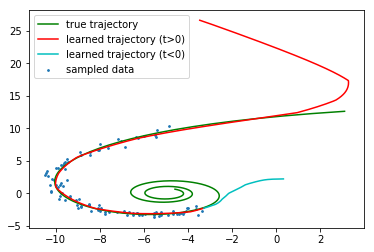

In [15]:
with torch.no_grad():
    # sample from trajectorys' approx. posterior
    h = rec.initHidden().to(device)
    for t in reversed(range(samp_trajs.size(1))):
        obs = samp_trajs[:, t, :]
        out, h = rec.forward(obs, h)
    qz0_mean, qz0_logvar = out[:, :latent_dim], out[:, latent_dim:]
    epsilon = torch.randn(qz0_mean.size()).to(device)
    z0 = epsilon * torch.exp(.5 * qz0_logvar) + qz0_mean
    orig_ts = torch.from_numpy(orig_ts).float().to(device)

    # take first trajectory for visualization
    z0 = z0[0]

    ts_pos = np.linspace(0., 2. * np.pi, num=2000)
    ts_neg = np.linspace(-np.pi, 0., num=2000)[::-1].copy()
    ts_pos = torch.from_numpy(ts_pos).float().to(device)
    ts_neg = torch.from_numpy(ts_neg).float().to(device)

    zs_pos = odeint(func, z0, ts_pos)
    zs_neg = odeint(func, z0, ts_neg)

    xs_pos = dec(zs_pos)
    xs_neg = torch.flip(dec(zs_neg), dims=[0])

xs_pos = xs_pos.cpu().numpy()
xs_neg = xs_neg.cpu().numpy()
orig_traj = orig_trajs[0].cpu().numpy()
samp_traj = samp_trajs[0].cpu().numpy()

plt.figure()
plt.plot(orig_traj[:, 0], orig_traj[:, 1],
         'g', label='true trajectory')
plt.plot(xs_pos[:, 0], xs_pos[:, 1], 'r',
         label='learned trajectory (t>0)')
plt.plot(xs_neg[:, 0], xs_neg[:, 1], 'c',
         label='learned trajectory (t<0)')
plt.scatter(samp_traj[:, 0], samp_traj[
            :, 1], label='sampled data', s=3)
plt.legend()
plt.savefig('./vis.png', dpi=500)
print('Saved visualization figure at {}'.format('./vis.png'))

In [16]:
z = zs_pos.cpu().numpy()

In [17]:
print(z.shape)

(2000, 4)


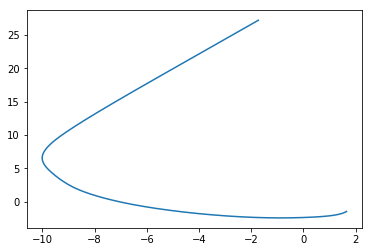

In [19]:
plt.plot(z[:,1], z[:,2])

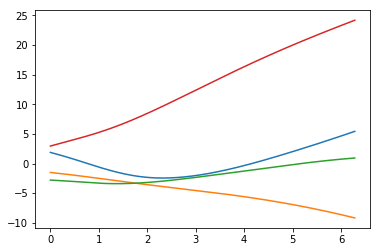

In [18]:
plt.plot(ts_pos.cpu().numpy(),z[:,0])
plt.plot(ts_pos.cpu().numpy(),z[:,1])
plt.plot(ts_pos.cpu().numpy(),z[:,2])
plt.plot(ts_pos.cpu().numpy(),z[:,3])